In [3]:
from scipy.io import mmread, mmwrite
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  ax.set(**{
      "xlim": lims,
      "ylim": lims,
      "aspect": "equal"
  })
  return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [4]:
mtx = mmread("tags_out/counts_filtered/cells_x_features.mtx").tocsr().astype(int)
genes = pd.read_csv("tags_out/counts_filtered/cells_x_features.genes.txt", header=None, names=["genes"])
barcodes = pd.read_csv("tags_out/counts_filtered/cells_x_features.barcodes.txt", header=None, names=["barcodes"])

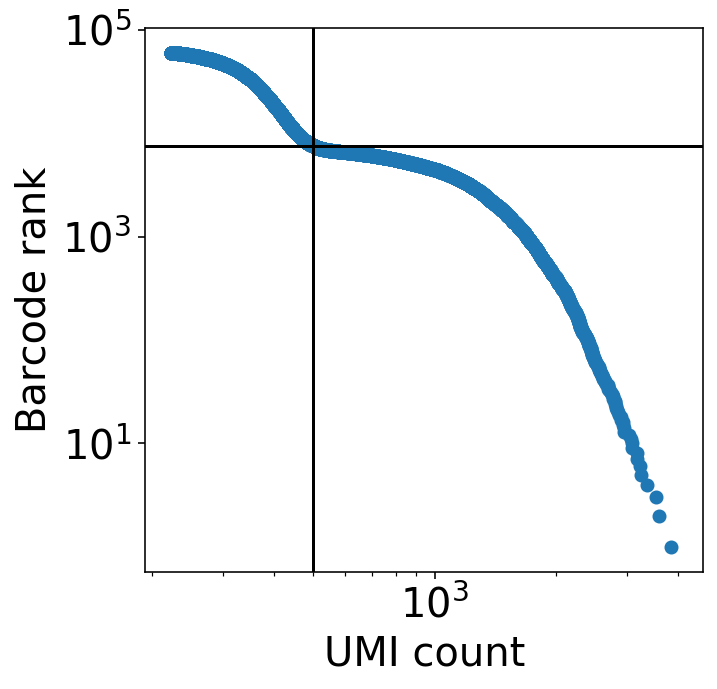

In [7]:
fig, ax = plt.subplots(figsize=(5,5))

x = np.sort(nd(mtx.sum(1)))[::-1]
y = np.arange(x.shape[0])

ax.scatter(x,y)
ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "UMI count",
    "ylabel": "Barcode rank"
})

lim = 500
ind = np.where(x > lim)[0][-1]
cutoff = x[ind]
ax.axvline(x=cutoff, color="k")
ax.axhline(y=ind, color="k")

fig.show()

In [8]:
print(f"{ind:,.0f} cells have more than {lim} UMI counts")

7,597 cells have more than 500 UMI counts


In [9]:
mask = nd(mtx.sum(1) > lim)

# Save filtered matrix, barcodes, genes, and dbco counts as cell metadata

In [11]:
!mkdir -p out
!cp tags_out/*.json out/

# masked barcodes
barcodes[mask].to_csv("out/barcodes.txt.gz", header=False, index=False, compression="gzip")

# genes without dbco
genes.query("genes != 'dbco'").to_csv("out/genes.txt.gz", header=False, index=False, compression="gzip")

# masked matrix (without barcodes or dbco)
mmwrite("out/matrix.mtx", mtx[mask][:,genes.genes.values!="dbco"])

# dbco vector
dbco = mtx[:,genes.genes.values=="dbco"].toarray().flatten()[mask]
pd.Series(dbco).to_csv("out/dbco.txt.gz", header=False, sep="\t", index=False, compression="gzip")

!gzip "out/matrix.mtx"

In [15]:
from sklearn.mixture import GaussianMixture
import json
from scipy.stats import entropy

In [16]:
gmm_params = {
            "n_components": 2,
            "means_init": None, # to be added
            "weights_init": None, # to be added
            "precisions_init": None, # to be added
            "random_state": 0,
            "reg_covar": 1e-8,
            "verbose": 2,
            "n_init": 1,
            "max_iter": 100,
            "tol": 1e-3,
            "init_params": "kmeans"
  }

params = {**gmm_params, 
#           "means_init": means_init, # centroids,
#           "weights_init": uniform_weights, 
#           "precisions_init": identity_precisions
          }

gmm = GaussianMixture(**params)

In [23]:
print(json.dumps(params, indent=4, default=str))

v = np.log1p(x).reshape(-1, 1)

labels = gmm.fit_predict(v)
means = gmm.means_
prob = gmm.predict_proba(v)
ent = entropy(prob, axis=1)

{
    "n_components": 2,
    "means_init": null,
    "weights_init": null,
    "precisions_init": null,
    "random_state": 0,
    "reg_covar": 1e-08,
    "verbose": 2,
    "n_init": 1,
    "max_iter": 100,
    "tol": 0.001,
    "init_params": "kmeans"
}
Initialization 0
Initialization converged: True	 time lapse 0.08474s	 ll -0.17458


(array([1.2498e+04, 2.8183e+04, 1.2847e+04, 9.4000e+02, 1.3140e+03,
        1.8590e+03, 1.8720e+03, 8.6000e+02, 1.6200e+02, 1.3000e+01]),
 array([5.40717177, 5.69598448, 5.98479719, 6.2736099 , 6.56242261,
        6.85123532, 7.14004802, 7.42886073, 7.71767344, 8.00648615,
        8.29529886]),
 <BarContainer object of 10 artists>)

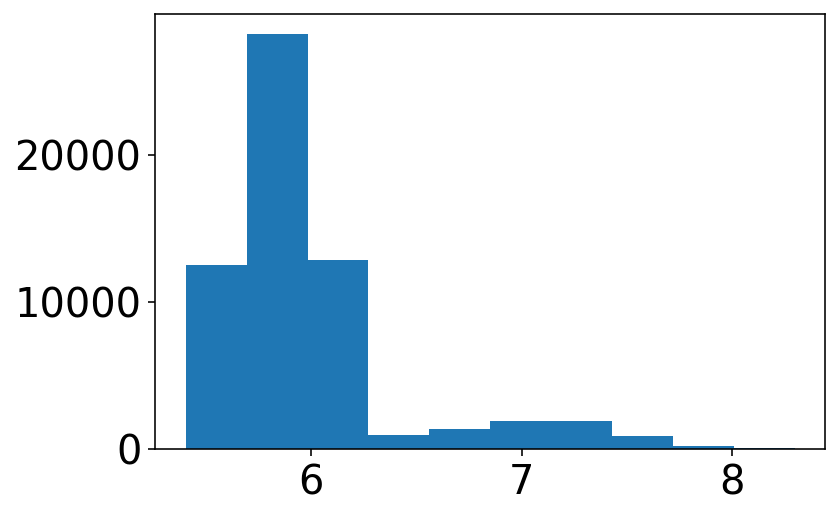

In [24]:
plt.hist(np.log1p(x))

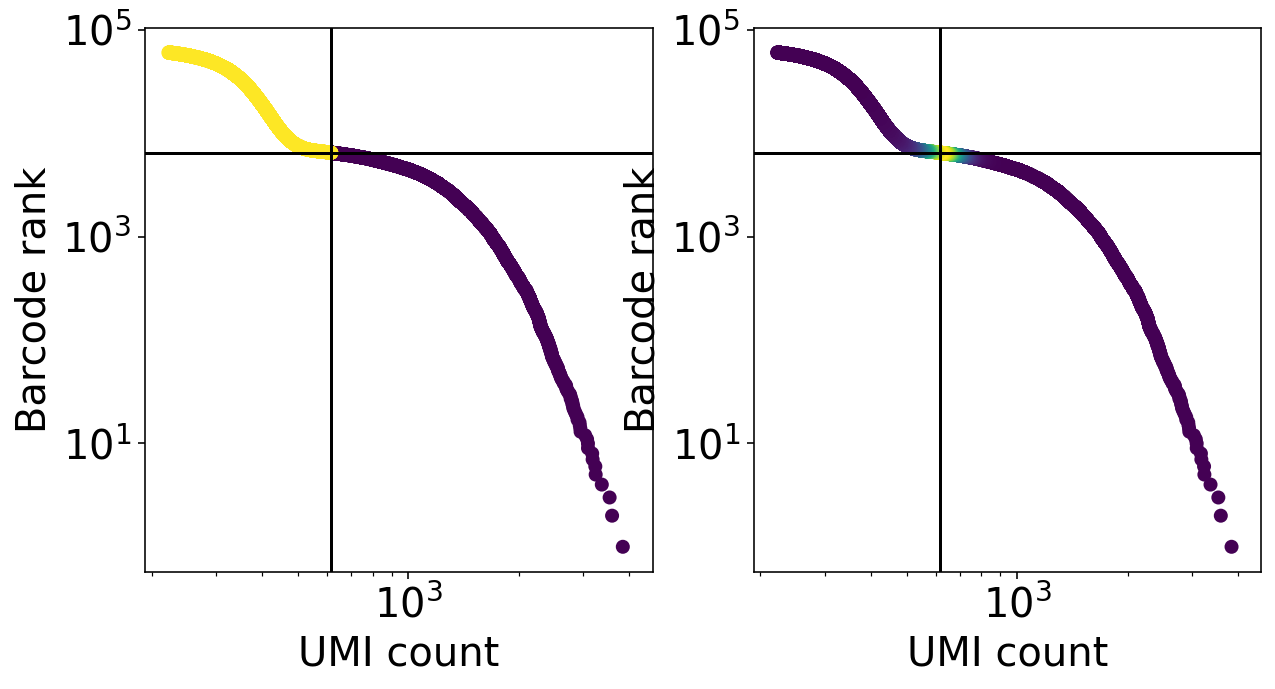

In [34]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2)

ax = axes[0]
x = np.sort(nd(mtx.sum(1)))[::-1]
y = np.arange(x.shape[0])

ax.scatter(x,y, c = labels)
ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "UMI count",
    "ylabel": "Barcode rank"
})


ind = np.where(labels == 1)[0][0]
cutoff = x[ind]

ax.axvline(x=cutoff, color="k")
ax.axhline(y=ind, color="k")

ax = axes[1]
x = np.sort(nd(mtx.sum(1)))[::-1]
y = np.arange(x.shape[0])

ax.scatter(x,y, c = ent)
ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "UMI count",
    "ylabel": "Barcode rank"
})


eind = np.argmax(ent)
cutoff = x[eind]
ax.axvline(x=cutoff, color="k")
ax.axhline(y=ind, color="k")

fig.show()

In [37]:
x.mean()

448.5811092026161

In [38]:
ind

6507

In [39]:
eind

6504

In [40]:
cutoff

618

In [43]:
np.median(x)

359.0

In [47]:
np.exp(means)-1

array([[1184.4181879 ],
       [ 344.47193424]])

In [48]:
gmm.covariances_

array([[[0.1179241 ]],

       [[0.03801735]]])